The estimation of Feature Importance based on a xgboost regression model. 

After removing the features with correlation value higher than 0.99, analyzing on the input data of the model was done to estimate the most important
features with respect to a xgboost model.
The Feature Importance is done according to two different approaches: 1.SHAP values which used to explain how each
feature affects the model and 2.xgboost Built-in Feature Importance(The XGBoost library provides a built-in function to plot features ordered by their importance).

In [19]:
#%load_ext autoreload
#%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import random
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score
from xgboost import XGBClassifier
import os
from sklearn.feature_selection import RFECV
import pandas as pd
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    KFold,
)
from sklearn.metrics import f1_score, mean_squared_error, mean_absolute_error, max_error
import numpy as np
from numpy.lib.function_base import average
import pandas as pd
import matplotlib.pyplot as plt

from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import (
    recall_score,
    f1_score,
    precision_score,
    confusion_matrix,
    make_scorer,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    KFold,
)
from sklearn.feature_selection import SelectKBest, SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import importlib
import os
from sklearn.feature_selection import (
    SelectKBest,
    RFE,
    mutual_info_regression,
    f_regression,
    mutual_info_classif,
)
from sklearn.preprocessing import RobustScaler
#import eli5
#from eli5.sklearn import PermutationImportance
from sklearn.inspection import permutation_importance
import xgboost as xgb
import random
import pickle
import openpyxl
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
import pickle
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
#import geopandas as gpd
import importlib


wor_dir="/home/mforooshani/Typhoon-Impact-based-forecasting-model-training-5:7/IBF-Typhoon-model/"
os.chdir(wor_dir)
cdir = os.getcwd()

combined_input_data=pd.read_csv("Training-data-new/data/model_input/combined_input_data.csv")

typhoons_with_impact_data=['bopha2012', 'conson2010', 'durian2006', 'fengshen2008',
       'fung-wong2014', 'goni2015', 'goni2020', 'hagupit2014',
       'haima2016', 'haiyan2013', 'jangmi2014', 'kalmaegi2014',
       'kammuri2019', 'ketsana2009', 'koppu2015', 'krosa2013',
       'linfa2015', 'lingling2014', 'mangkhut2018', 'mekkhala2015',
       'melor2015', 'meranti2016', 'molave2020', 'mujigae2015',
       'nakri2019', 'nari2013', 'nesat2011', 'nock-ten2016', 'noul2015',
       'phanfone2019', 'rammasun2014', 'sarika2016', 'saudel2020',
       'tokage2016', 'trami2013', 'usagi2013', 'utor2013', 'vamco2020',
       'vongfong2020', 'yutu2018']

len(np.unique(combined_input_data.typhoon))
combined_input_data=combined_input_data[combined_input_data.typhoon.isin(typhoons_with_impact_data)]


def set_zeros(x):
    x_max = 25
    y_max = 50
    
    v_max = x[0]
    rainfall_max = x[1]
    damage = x[2]
    if pd.notnull(damage):
        value = damage
    elif v_max > x_max or rainfall_max > y_max:
        value =damage
    elif (v_max < np.sqrt((1- (rainfall_max**2/y_max ** 2))*x_max ** 2)):
        value = 0
    else:
        value = np.nan

    return value
combined_input_data["DAM_perc_dmg"] = combined_input_data[["HAZ_v_max", "HAZ_rainfall_Total", "DAM_perc_dmg"]].apply(set_zeros, axis="columns")


np.mean(combined_input_data["DAM_perc_dmg"])
combined_input_data = combined_input_data[combined_input_data['DAM_perc_dmg'].notnull()]
np.mean(combined_input_data["DAM_perc_dmg"])
np.unique(combined_input_data.typhoon)

def cubeic(x):
    #x=float(x)
    value=x*x*x
    return value

combined_input_data['HAZ_v_max_3']=combined_input_data['HAZ_v_max'].apply(lambda x: x*x*x) 
#display(combined_input_data)
#combined_input_data.hist(column="DAM_perc_dmg") 

combined_input_data =combined_input_data.filter(['typhoon','HAZ_rainfall_Total', 
        'HAZ_rainfall_max_6h',
        'HAZ_rainfall_max_24h',
        'HAZ_v_max',
        'HAZ_v_max_3',
        'HAZ_dis_track_min',
        'GEN_landslide_per',
        'GEN_stormsurge_per',
        'GEN_Bu_p_inSSA', 
        'GEN_Bu_p_LS', 
        'GEN_Red_per_LSbldg',
        'GEN_Or_per_LSblg', 
        'GEN_Yel_per_LSSAb', 
        'GEN_RED_per_SSAbldg',
        'GEN_OR_per_SSAbldg',
        'GEN_Yellow_per_LSbl',
        'TOP_mean_slope',
        'TOP_mean_elevation_m', 
        'TOP_ruggedness_stdev', 
        'TOP_mean_ruggedness',
        'TOP_slope_stdev', 
        'VUL_poverty_perc',
        'GEN_with_coast',
        'GEN_coast_length', 
        'VUL_Housing_Units',
        'VUL_StrongRoof_StrongWall', 
        'VUL_StrongRoof_LightWall',
        'VUL_StrongRoof_SalvageWall', 
        'VUL_LightRoof_StrongWall',
        'VUL_LightRoof_LightWall', 
        'VUL_LightRoof_SalvageWall',
        'VUL_SalvagedRoof_StrongWall',
        'VUL_SalvagedRoof_LightWall',
        'VUL_SalvagedRoof_SalvageWall', 
        'VUL_vulnerable_groups',
        'VUL_pantawid_pamilya_beneficiary', 
        'DAM_perc_dmg'])


features_name = combined_input_data.columns
#display(features_name)

#Dropping highly correlated features (correlation value > 0.99) from X data.
features =['HAZ_rainfall_Total', 
        'HAZ_rainfall_max_6h',
        'HAZ_rainfall_max_24h',
        'HAZ_v_max',
        'HAZ_v_max_3',
        'HAZ_dis_track_min',
        'GEN_landslide_per',
        'GEN_stormsurge_per',
        #'GEN_Bu_p_inSSA', 
        #'GEN_Bu_p_LS', 
        'GEN_Red_per_LSbldg',
        'GEN_Or_per_LSblg', 
        'GEN_Yel_per_LSSAb', 
        #'GEN_RED_per_SSAbldg',
        'GEN_OR_per_SSAbldg',
        'GEN_Yellow_per_LSbl',
        'TOP_mean_slope',
        'TOP_mean_elevation_m', 
        'TOP_ruggedness_stdev', 
        #'TOP_mean_ruggedness',
        #'TOP_slope_stdev', 
        'VUL_poverty_perc',
        'GEN_with_coast',
        'GEN_coast_length', 
        'VUL_Housing_Units',
        'VUL_StrongRoof_StrongWall', 
        'VUL_StrongRoof_LightWall',
        'VUL_StrongRoof_SalvageWall', 
        'VUL_LightRoof_StrongWall',
        'VUL_LightRoof_LightWall', 
        'VUL_LightRoof_SalvageWall',
        'VUL_SalvagedRoof_StrongWall',
        'VUL_SalvagedRoof_LightWall',
        'VUL_SalvagedRoof_SalvageWall', 
        'VUL_vulnerable_groups',
        'VUL_pantawid_pamilya_beneficiary'
          ]


df=combined_input_data.dropna()
display(df)



,typhoon,HAZ_rainfall_Total,HAZ_rainfall_max_6h,HAZ_rainfall_max_24h,HAZ_v_max,HAZ_v_max_3,HAZ_dis_track_min,GEN_landslide_per,GEN_stormsurge_per,GEN_Bu_p_inSSA,...,VUL_StrongRoof_SalvageWall,VUL_LightRoof_StrongWall,VUL_LightRoof_LightWall,VUL_LightRoof_SalvageWall,VUL_SalvagedRoof_StrongWall,VUL_SalvagedRoof_LightWall,VUL_SalvagedRoof_SalvageWall,VUL_vulnerable_groups,VUL_pantawid_pamilya_beneficiary,DAM_perc_dmg
0,durian2006,185.828571,14.716071,7.381696,55.032241,166667.757548,2.478142,2.64,6.18,6.18,...,0.097425,2.533055,41.892832,1.002088,0.000000,0.027836,0.083507,2.951511,46.931106,3.632568
2,durian2006,8.818750,0.455208,0.255319,8.728380,664.968323,288.358553,0.06,0.00,0.00,...,0.850008,1.218595,13.645253,0.549120,0.030089,0.090266,0.112833,3.338873,25.989168,0.000000
4,durian2006,24.175000,2.408333,0.957639,10.945624,1311.358762,274.953818,1.52,1.28,1.28,...,0.197179,0.667374,15.592295,0.075838,0.000000,0.015168,0.075838,2.131755,32.185651,0.000000
6,durian2006,14.930000,1.650000,0.586250,12.108701,1775.385328,252.828578,0.00,0.00,0.00,...,0.279362,0.675125,7.100454,0.023280,0.011640,0.000000,0.128041,1.589369,29.612385,0.000000
7,durian2006,13.550000,1.054167,0.528125,10.660943,1211.676901,258.194381,5.52,0.36,0.36,...,0.065703,0.821288,30.354796,0.000000,0.000000,0.032852,0.000000,1.387007,35.052562,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25835,noul2015,9.700000,0.408333,0.216146,8.136932,538.743551,277.107823,1.80,6.25,6.25,...,0.186916,3.613707,32.492212,0.311526,0.031153,0.155763,0.031153,2.827833,31.308411,0.000000
25837,noul2015,17.587500,1.414583,0.386458,9.818999,946.676507,305.789817,0.00,0.00,0.00,...,0.209059,0.383275,4.703833,0.027875,0.000000,0.034843,0.097561,1.073268,12.766551,0.000000
25838,noul2015,11.487500,0.614583,0.230319,15.791907,3938.254316,210.313249,0.06,0.09,0.09,...,0.202748,0.090110,3.063753,0.022528,0.000000,0.067583,0.022528,1.140109,9.348952,0.000000
25839,noul2015,11.600000,1.400000,0.412766,13.867145,2666.620370,218.189328,0.00,0.00,0.00,...,0.000000,0.094518,3.119093,0.000000,0.000000,0.000000,0.000000,2.837537,21.928166,0.000000


In [20]:
#df = df[df.DAM_perc_dmg != 0] 
#df

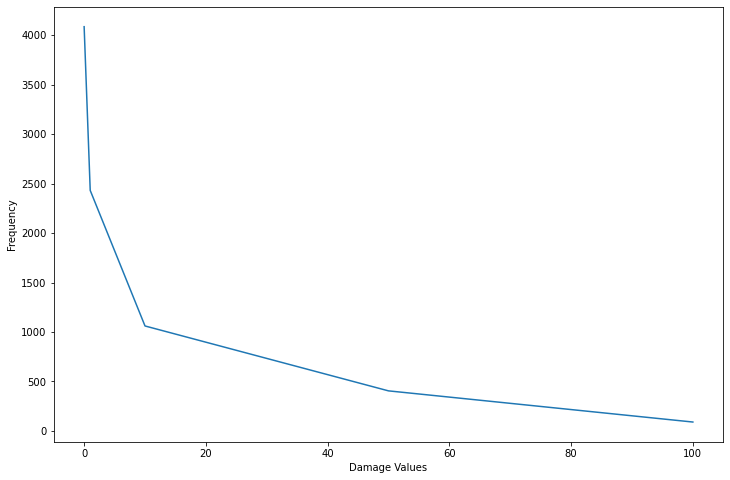

In [21]:
#The Old and New set of bins
#bins2= [0, 1, 60, 100]
bins2 = [0, 0.00009, 1, 10, 50, 100]
samples_per_bin2, binsP2 = np.histogram(df['DAM_perc_dmg'], bins=bins2)
plt.xlabel("Damage Values")
plt.ylabel("Frequency")
plt.plot(binsP2[1:],samples_per_bin2)

In [22]:
print(samples_per_bin2)
print(binsP2)

[4086 2431 1061  405   90]
[0.e+00 9.e-05 1.e+00 1.e+01 5.e+01 1.e+02]


In [23]:
bin_index2=np.digitize(df['DAM_perc_dmg'], bins=binsP2)

In [24]:
y_input_strat=bin_index2

In [25]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

X = df[features]
display(X.columns)
y = df["DAM_perc_dmg"]

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled,df['DAM_perc_dmg'], stratify=y_input_strat, test_size=0.2, 
                                                    #random_state=42
                                                   ) 


#print(X_train.shape, y_train.shape)
#print(X_test.shape, y_test.shape)


Index(['HAZ_rainfall_Total', 'HAZ_rainfall_max_6h', 'HAZ_rainfall_max_24h',
       'HAZ_v_max', 'HAZ_v_max_3', 'HAZ_dis_track_min', 'GEN_landslide_per',
       'GEN_stormsurge_per', 'GEN_Red_per_LSbldg', 'GEN_Or_per_LSblg',
       'GEN_Yel_per_LSSAb', 'GEN_OR_per_SSAbldg', 'GEN_Yellow_per_LSbl',
       'TOP_mean_slope', 'TOP_mean_elevation_m', 'TOP_ruggedness_stdev',
       'VUL_poverty_perc', 'GEN_with_coast', 'GEN_coast_length',
       'VUL_Housing_Units', 'VUL_StrongRoof_StrongWall',
       'VUL_StrongRoof_LightWall', 'VUL_StrongRoof_SalvageWall',
       'VUL_LightRoof_StrongWall', 'VUL_LightRoof_LightWall',
       'VUL_LightRoof_SalvageWall', 'VUL_SalvagedRoof_StrongWall',
       'VUL_SalvagedRoof_LightWall', 'VUL_SalvagedRoof_SalvageWall',
       'VUL_vulnerable_groups', 'VUL_pantawid_pamilya_beneficiary'],
      dtype='object')

In [26]:
# create an xgboost regression model

xgb = XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, gamma=1, reg_lambda=0.1, colsample_bytree=0.8 
                   #,random_state=42
                  )
xgb_model=xgb.fit(X_train, y_train)


#With ReducedOverfitting
#xgb = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
#                   colsample_bynode=0.8, colsample_bytree=0.8, gamma=3, eta=0.01,
#                   importance_type='gain', learning_rate=0.1, max_delta_step=0,
#                   max_depth=4, min_child_weight=1, missing=1, n_estimators=100, early_stopping_rounds=10,
#                   n_jobs=1, nthread=None, objective='reg:squarederror', random_state=0,
#                   reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
#                   silent=None, subsample=0.8, verbosity=1, eval_metric=["rmse", "logloss"])

    
#eval_set = [(X_test, y_test)]
#xgb_model=xgb.fit(X_train, y_train, eval_set=eval_set, verbose=False)


In [27]:
X_train4shapely=pd.DataFrame(data=X_train,columns=features)

In [28]:
import shap
explainer_xgb = shap.Explainer(xgb_model, X_train4shapely)
shap_values_xgb = explainer_xgb(X_train4shapely)


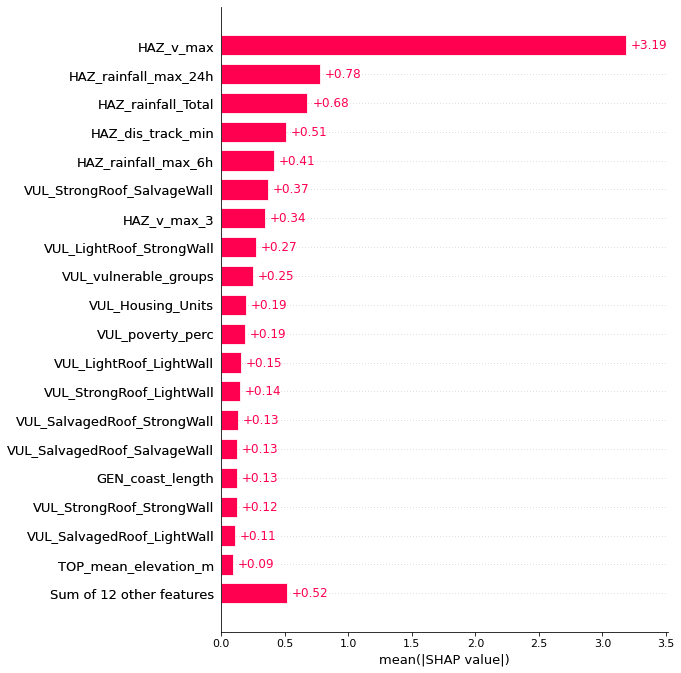

In [29]:
#Showing Barplot

#shap.plots.beeswarm(shap_values_xgb.abs, color="shap_red", max_display=20)
#shap.plots.bar(shap_values_xgb.abs.mean(0), max_display=20)

shap.plots.bar(shap_values_xgb, max_display=20)

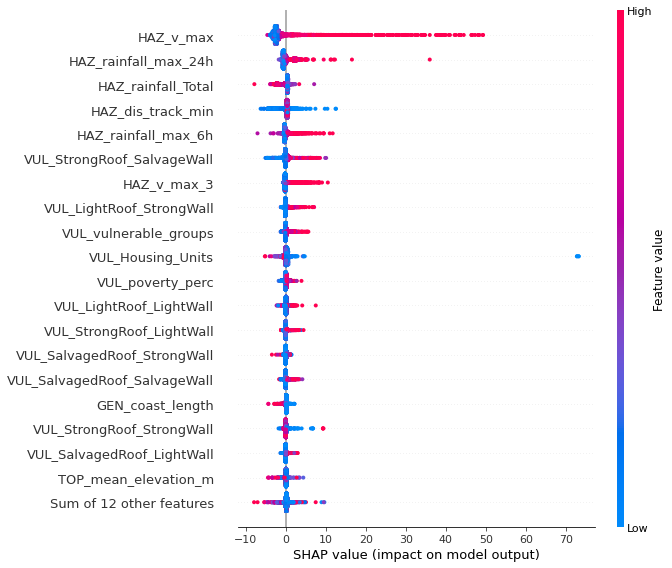

In [30]:
#Showing Beeswarm Plot
shap.plots.beeswarm(shap_values_xgb, max_display=20, #order=shap_values_xgb.abs.max(0)#, color="shap_red"
                   )

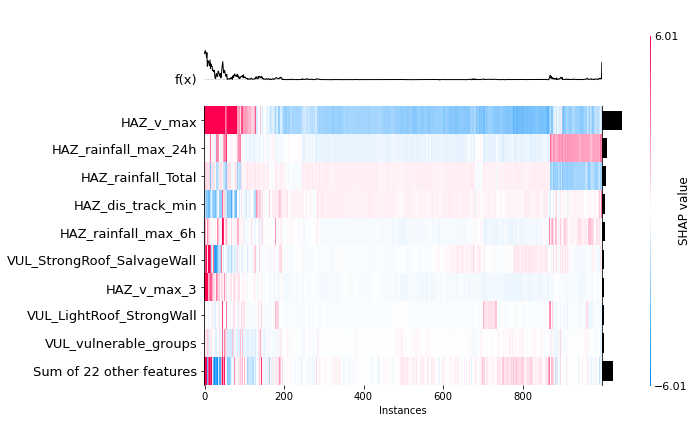

In [31]:
#Showing Heatmap 
shap.plots.heatmap(shap_values_xgb[:1000])

Text(0.5, 0, 'Xgboost Feature Importance')

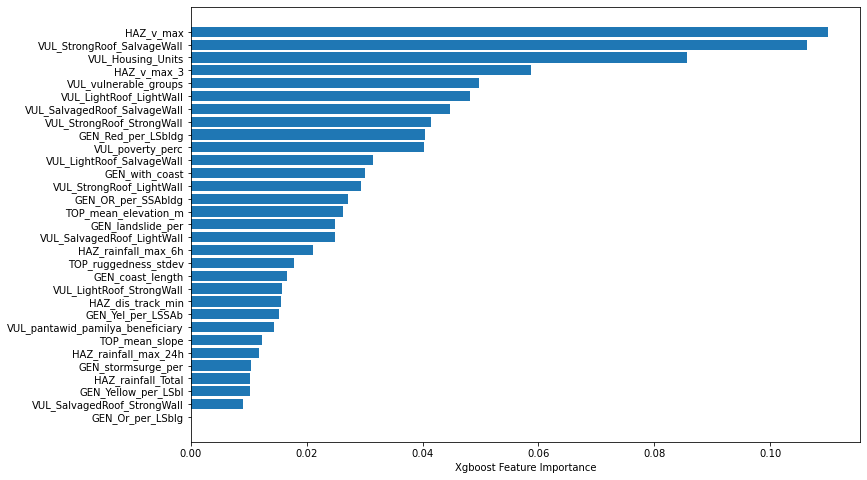

In [32]:
#Xgboost Built-in Feature Importance

plt.rcParams.update({'figure.figsize': (12.0, 8.0)})
plt.rcParams.update({'font.size': 10})

sorted_idx = xgb.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], xgb.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

import shap explainer = shap.TreeExplainer(xgb) shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [33]:
"""
Showing X data illustrates that 5 highly correlated features with the value higher than 0.99 were removed 
before applying feature importance methods on input data.
"""
X

,HAZ_rainfall_Total,HAZ_rainfall_max_6h,HAZ_rainfall_max_24h,HAZ_v_max,HAZ_v_max_3,HAZ_dis_track_min,GEN_landslide_per,GEN_stormsurge_per,GEN_Red_per_LSbldg,GEN_Or_per_LSblg,...,VUL_StrongRoof_LightWall,VUL_StrongRoof_SalvageWall,VUL_LightRoof_StrongWall,VUL_LightRoof_LightWall,VUL_LightRoof_SalvageWall,VUL_SalvagedRoof_StrongWall,VUL_SalvagedRoof_LightWall,VUL_SalvagedRoof_SalvageWall,VUL_vulnerable_groups,VUL_pantawid_pamilya_beneficiary
0,185.828571,14.716071,7.381696,55.032241,166667.757548,2.478142,2.64,6.18,1.17,0.03,...,8.211552,0.097425,2.533055,41.892832,1.002088,0.000000,0.027836,0.083507,2.951511,46.931106
2,8.818750,0.455208,0.255319,8.728380,664.968323,288.358553,0.06,0.00,0.06,0.00,...,33.639236,0.850008,1.218595,13.645253,0.549120,0.030089,0.090266,0.112833,3.338873,25.989168
4,24.175000,2.408333,0.957639,10.945624,1311.358762,274.953818,1.52,1.28,0.02,0.00,...,22.963749,0.197179,0.667374,15.592295,0.075838,0.000000,0.015168,0.075838,2.131755,32.185651
6,14.930000,1.650000,0.586250,12.108701,1775.385328,252.828578,0.00,0.00,0.00,0.00,...,16.179723,0.279362,0.675125,7.100454,0.023280,0.011640,0.000000,0.128041,1.589369,29.612385
7,13.550000,1.054167,0.528125,10.660943,1211.676901,258.194381,5.52,0.36,0.00,0.00,...,32.522996,0.065703,0.821288,30.354796,0.000000,0.000000,0.032852,0.000000,1.387007,35.052562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25835,9.700000,0.408333,0.216146,8.136932,538.743551,277.107823,1.80,6.25,0.12,0.00,...,19.563863,0.186916,3.613707,32.492212,0.311526,0.031153,0.155763,0.031153,2.827833,31.308411
25837,17.587500,1.414583,0.386458,9.818999,946.676507,305.789817,0.00,0.00,0.00,0.00,...,13.456446,0.209059,0.383275,4.703833,0.027875,0.000000,0.034843,0.097561,1.073268,12.766551
25838,11.487500,0.614583,0.230319,15.791907,3938.254316,210.313249,0.06,0.09,0.06,0.00,...,22.347376,0.202748,0.090110,3.063753,0.022528,0.000000,0.067583,0.022528,1.140109,9.348952
25839,11.600000,1.400000,0.412766,13.867145,2666.620370,218.189328,0.00,0.00,0.00,0.00,...,29.584121,0.000000,0.094518,3.119093,0.000000,0.000000,0.000000,0.000000,2.837537,21.928166
